# <center> HDBSCAN: Split on Cluster Stability </center>

Here, I explore the idea of splitting HDBSCAN clusters when new data arises that indicates that the cluster should be split (on the basis of cluster stability). Take a look at the `hdbscan.md` file for a more detailed explanation of HDBSCAN.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
# sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

### Create the data

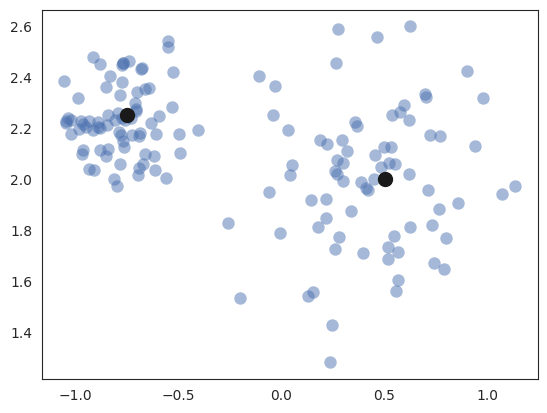

In [2]:
centers = np.array([[-0.75,2.25],[0.5, 2.0]])
blobs1, _ = data.make_blobs(n_samples=75, centers=[centers[0]], cluster_std=0.15)
blobs2, _ = data.make_blobs(n_samples=75, centers=[centers[1]], cluster_std=0.3)
test_data = np.concatenate((blobs1, blobs2))
plt.scatter(*test_data.T, color='b', **plot_kwds)
plt.scatter(centers[:,0], centers[:,1], color='k', s=100)
plt.show()

### Run Clustering

In [3]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=5, allow_single_cluster=True, gen_min_span_tree=True)
clusterer.fit(test_data)

HDBSCAN(allow_single_cluster=True, gen_min_span_tree=True)

<Axes: >

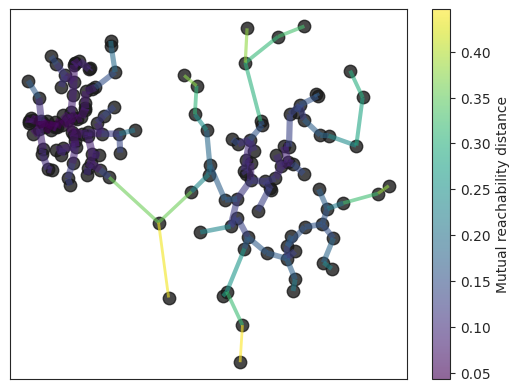

In [4]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<Axes: ylabel='$\\lambda$ value'>

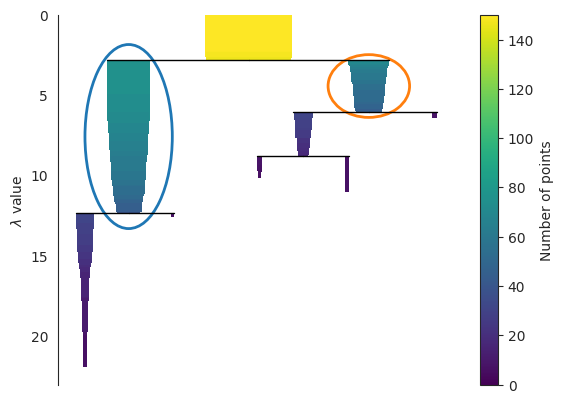

In [5]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

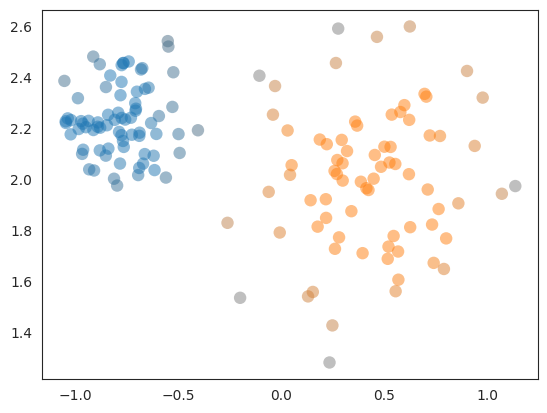

In [6]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

## Now try restricting the test data and iteratively adding points

In [7]:
mask = test_data.T[0] < 0.
test_data_reduced = test_data[mask]
len(test_data_reduced)

82

In [8]:
clusterer = HDBSCAN(min_cluster_size=5, allow_single_cluster=True, gen_min_span_tree=True, prediction_data=True)
clusterer.fit(test_data_reduced)

HDBSCAN(allow_single_cluster=True, gen_min_span_tree=True, prediction_data=True)

<Axes: >

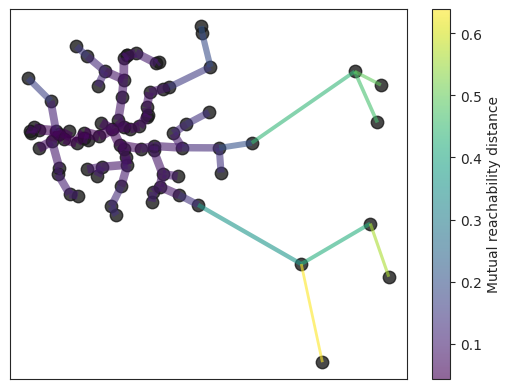

In [9]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<Axes: ylabel='$\\lambda$ value'>

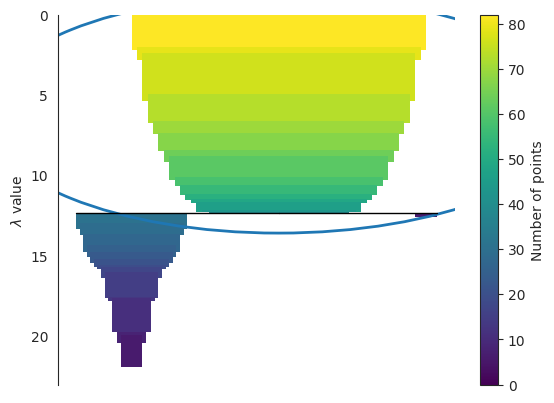

In [10]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

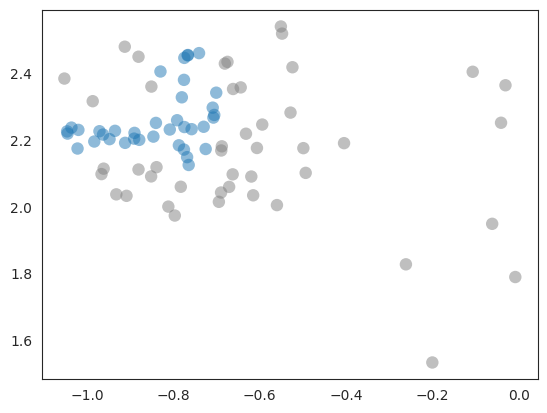

In [11]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(*test_data_reduced.T, c=cluster_colors, **plot_kwds)

Okay, so we only have a single cluster (or all noise) in the data. Let's try adding points iteratively to see if we can split the cluster with our method. We first need a way to approximate the cluster stability.

In [12]:
from hdbscan.prediction import _extend_condensed_tree, _find_neighbor_and_lambda
from hdbscan._prediction_utils import get_tree_row_with_child
from hdbscan._hdbscan_tree import compute_stability
from scipy.spatial import KDTree

# TODO: THIS HAS NOT BEEN FINISHED. IT TOOK TOO LONG SO I DID IT FOR A SINGLE POINT

def is_stable(clusterer, new_points):
    # Check that the clusterer has prediction data
    if clusterer.prediction_data_ is None:
        raise ValueError('Clusterer does not have prediction data!'
                         ' Try fitting with prediction_data=True set,'
                         ' or run generate_prediction_data on the clusterer')
    prediction_data = clusterer.prediction_data_

    # Check that the new points have the same dimension as the fit data
    new_points = np.asarray(new_points)
    if new_points.shape[1] != prediction_data.raw_data.shape[1]:
        raise ValueError('New points dimension does not match fit data!')
    
    k = clusterer.min_samples or 5
    n = prediction_data.raw_data.shape[0]
    n_new = new_points.shape[0]
    aug_data = np.vstack((prediction_data.raw_data, new_points))    # Augmented data
    
    ## edited from _hdbscan_prims_kdtree
    indices = prediction_data.tree.query(new_points, k=2*k)[1]  # Get the 2*k nearest neighbors in the original data
    neighbors = prediction_data.raw_data[np.unique(indices)]    # Get the unique neighbors
    X = np.vstack((neighbors, new_points))                      # Combine the neighbors and new points
    distances, new_indices = KDTree(X).query(X, k=k+1)          # Get the distances and indices of the k+1 nearest neighbors

    # Get distance to kth nearest neighbour
    core_distances = tree.query(
        X, k=min_samples + 1, dualtree=True, breadth_first=True
    )[0][:, -1].copy(order="C")

    # Compute nearest neighbors of the new points
    new_distances, new_indices = KDTree(new_points).query(new_points, k=min(n_new, k+1))
    new_indices += n
    
    # Sort the distances and indices                                # TODO: This is probably slow
    distances = np.hstack((distances, new_distances[:,1:]))         # Remove self-distance
    indices = np.hstack((indices, new_indices[:,1:]))
    sort_ind = np.argsort(distances, axis=1, type='mergesort')      # Sort the new distances and distances from old points
    distances = np.take_along_axis(distances, sort_ind, axis=1)
    indices = np.take_along_axis(indices, sort_ind, axis=1)

    new_core_distances = distances[:,k-1]
    core_distances = np.hstack((prediction_data.core_distances, new_core_distances))



    ## _find_neighbor_and_lambda(neighbor_indices, neighbor_distances, core_distances, min_samples)
    # neighbor_core_distances = core_distances[neighbor_indices]              # We only need the core distances of the neighbors
    # point_core_distances = neighbor_distances[min_samples] * np.ones(       # And the core distance of the new point
    #     neighbor_indices.shape[0])
    # mr_distances = np.vstack((                                              # Compute the mutual reachability distance
    #     neighbor_core_distances,
    #     point_core_distances,
    #     neighbor_distances
    # )).max(axis=0)

    # nn_index = mr_distances.argmin()

    # nearest_neighbor = neighbor_indices[nn_index]                           # Only need to find the nearest neighbor in MRD      
    # if mr_distances[nn_index] > 0.0:
    #     lambda_ = 1. / mr_distances[nn_index]
    # else:
    #     lambda_ = np.finfo(np.double).max

    # return nearest_neighbor, lambda_

    
    

    ## _extend_condensed_tree(tree, neighbor_indices, neighbor_distances, core_distances, min_samples)
    # tree_root = tree['parent'].min()

    # nearest_neighbor, lambda_ = _find_neighbor_and_lambda(neighbor_indices,
    #                                                       neighbor_distances,
    #                                                       core_distances,
    #                                                       min_samples
    #                                                       )

    # neighbor_tree_row = get_tree_row_with_child(tree, nearest_neighbor)
    # potential_cluster = neighbor_tree_row['parent']

    # if neighbor_tree_row['lambda_val'] <= lambda_:
    #     # New point departs with the old
    #     new_tree_row = (potential_cluster, -1, 1,
    #                     neighbor_tree_row['lambda_val'])
    # else:
    #     # Find appropriate cluster based on lambda of new point
    #     while potential_cluster > tree_root and \
    #             tree[tree['child']
    #                  == potential_cluster]['lambda_val'] >= lambda_:
    #         potential_cluster = tree['parent'][tree['child'] == potential_cluster][0]

    #     new_tree_row = (potential_cluster, -1, 1, lambda_)

    # return np.append(tree, new_tree_row)


    # # Extend the condensed tree with the new points
    # condensed_tree = _extend_condensed_tree(
    #     tree = clusterer.condensed_tree_,
    #     neighbor_indices = ,
    #     neighbor_distances = ,
    #     core_distances = ,
    #     min_samples = clusterer.min_samples,
    # )


In [13]:
from hdbscan.prediction import _find_neighbor_and_lambda

def _extend_condensed_tree(tree, neighbor_indices, neighbor_distances,
                           core_distances, min_samples):
    """
    Create a new condensed tree with an additional point added, allowing for
    computations as if this point had been part of the original tree. Note
    that this makes as little change to the tree as possible, with no
    re-optimizing/re-condensing so that the selected clusters remain
    effectively unchanged.

    Parameters
    ----------
    tree : structured array
        The raw format condensed tree to update.

    neighbor_indices : array (2 * min_samples, )
        An array of raw distance based nearest neighbor indices.

    neighbor_distances : array (2 * min_samples, )
        An array of raw distances to the nearest neighbors.

    core_distances : array (n_samples, )
        An array of core distances for all points

    min_samples : int
        The min_samples value used to generate core distances.

    Returns
    -------
    new_tree : structured array
        The original tree with an extra row providing the parent cluster
        and lambda information for a new point given index -1.
    """
    tree_root = tree['parent'].min()

    nearest_neighbor, lambda_ = _find_neighbor_and_lambda(neighbor_indices,
                                                          neighbor_distances,
                                                          core_distances,
                                                          min_samples
                                                          )

    neighbor_tree_row = get_tree_row_with_child(tree, nearest_neighbor)
    potential_cluster = neighbor_tree_row['parent']

    if neighbor_tree_row['lambda_val'] <= lambda_:
        # New point departs with the old
        new_tree_row = (potential_cluster, -1, neighbor_tree_row['lambda_val'], 1)
    else:
        # Find appropriate cluster based on lambda of new point
        child_mask = tree['child'] == potential_cluster
        while potential_cluster > tree_root and tree[child_mask]['lambda_val'] >= lambda_:
            potential_cluster = tree['parent'][child_mask][0]

        new_tree_row = (potential_cluster, -1, lambda_, 1)

    new_tree_row = np.array(new_tree_row, dtype=tree.dtype)

    return np.append(tree, new_tree_row)

In [45]:
from hdbscan._prediction_utils import get_tree_row_with_child
from hdbscan._hdbscan_tree import compute_stability, get_clusters
from scipy.spatial import KDTree

def is_stable(clusterer, new_point):
    prediction_data = clusterer.prediction_data_
    new_points = np.asarray(new_point).reshape(1, -1)
    min_samples = 5

    distances, indices = prediction_data.tree.query(new_points, k=2*min_samples)
    core_distances = prediction_data.core_distances

    condensed_tree = clusterer.condensed_tree_._raw_tree
    extended_condensed_tree = _extend_condensed_tree(condensed_tree, indices.squeeze(), distances.squeeze(),
                                                     core_distances, min_samples)
    
    stability = compute_stability(extended_condensed_tree)

    # Traverse the tree from the leaves to the root (this includes the root for single cluster) 
    return get_clusters(clusterer.condensed_tree_._raw_tree, stability,
                        allow_single_cluster=True) 

In [90]:
# Add points back in and predict

# mask = (test_data.T[0] >= 0.) 
# new_points = test_data[mask]
# len(new_points)

new_points = np.array([[-0.15, 1.8],
                       [-0.2, 1.6],
                       [-0.1, 1.7],])

In [91]:
is_stable(clusterer, new_points[0])

(array([-1,  0,  0, -1, -1,  0,  0,  0, -1,  0,  0,  0,  0, -1, -1, -1, -1,
        -1, -1,  0, -1, -1, -1, -1, -1, -1,  0, -1,  0, -1,  0, -1, -1,  0,
        -1, -1,  0,  0,  0, -1,  0, -1,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        -1,  0,  0, -1,  0,  0,  0,  0, -1, -1, -1, -1, -1,  0,  0,  0,  0,
        -1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]),
 array([0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1.05040204]))

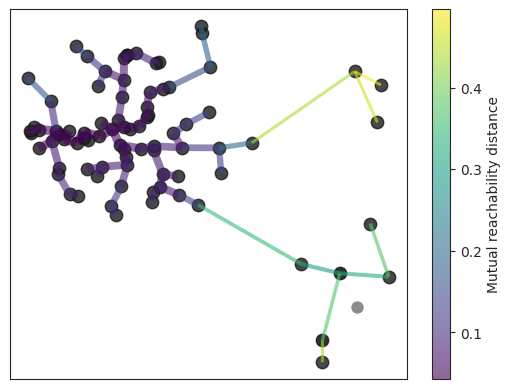

In [92]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)
plt.scatter(*new_points.T, color='k', **plot_kwds)

In [93]:
clusterer = HDBSCAN(min_cluster_size=5, allow_single_cluster=True, gen_min_span_tree=True, prediction_data=True)
clusterer.fit(np.vstack((test_data_reduced, new_points)))

HDBSCAN(allow_single_cluster=True, gen_min_span_tree=True, prediction_data=True)

<Axes: >

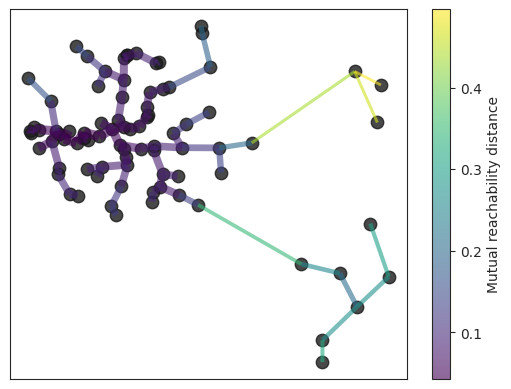

In [94]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<Axes: ylabel='$\\lambda$ value'>

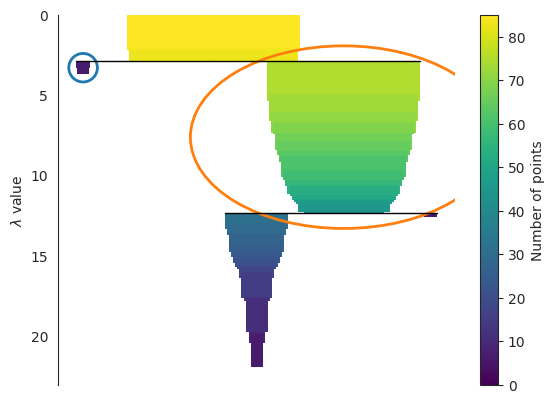

In [95]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [ ]:
clusterer.__dict__

In [ ]:
clusterer._prediction_data.__dict__